In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
file_path = "sireNNet/espectrogramas_sirennet/sirennet_espectrograma.csv"
df = pd.read_csv(file_path)
df.head()

,class,spectrogram_path
0,ambulance,./sireNNet/espectrogramas_sirennet\ambulance\s...
1,ambulance,./sireNNet/espectrogramas_sirennet\ambulance\s...
2,ambulance,./sireNNet/espectrogramas_sirennet\ambulance\s...
3,ambulance,./sireNNet/espectrogramas_sirennet\ambulance\s...
4,ambulance,./sireNNet/espectrogramas_sirennet\ambulance\s...


In [5]:
df = df[df.isin(["ambulance", "police", "firetruck"]).any(axis=1)]


In [4]:
df[df['class']=='ambulance'].count()

class               400
spectrogram_path    400
dtype: int64

In [5]:
df[df['class']=='police'].count()

class               454
spectrogram_path    454
dtype: int64

In [7]:
df[df['class']=='car_horn'].count()

class               429
spectrogram_path    429
dtype: int64

In [9]:
df[df['class']=='firetruck'].count()

class               400
spectrogram_path    400
dtype: int64

In [3]:
# Ver porcentaje de cada clase
porcentajes = df['class'].value_counts(normalize=True) * 100

# Mostrar redondeado
print(porcentajes.round(2))


class
police       26.98
car_horn     25.49
ambulance    23.77
firetruck    23.77
Name: proportion, dtype: float64


In [3]:
df['spectrogram_path'] = df['spectrogram_path'].apply(lambda x: x.replace("\\", "/"))
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['class'])

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

IMG_SIZE = (128, 128)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def load_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0 
    return image, label

def create_dataset(df):
    paths = df['spectrogram_path'].values
    labels = df['label'].values
    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    dataset = dataset.map(load_image, num_parallel_calls=AUTOTUNE)
    return dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

train_ds = create_dataset(train_df)
val_ds = create_dataset(val_df)

In [4]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(128, 128, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(label_encoder.classes_), activation='softmax')
])

In [5]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.0001)
model.compile(
    optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

history = model.fit(
    train_ds, validation_data=val_ds, epochs=40, verbose=1, batch_size=32, shuffle=True
)

Epoch 1/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 179ms/step - accuracy: 0.2644 - loss: 1.3912 - val_accuracy: 0.4273 - val_loss: 1.3455
Epoch 2/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step - accuracy: 0.3445 - loss: 1.3459 - val_accuracy: 0.5401 - val_loss: 1.2351
Epoch 3/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - accuracy: 0.4694 - loss: 1.2344 - val_accuracy: 0.7033 - val_loss: 0.9711
Epoch 4/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 168ms/step - accuracy: 0.6500 - loss: 0.9878 - val_accuracy: 0.8220 - val_loss: 0.6918
Epoch 5/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 167ms/step - accuracy: 0.6955 - loss: 0.8076 - val_accuracy: 0.8160 - val_loss: 0.5652
Epoch 6/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - accuracy: 0.7706 - loss: 0.6407 - val_accuracy: 0.8605 - val_loss: 0.4603
Epoch 7/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - accuracy: 0.8028 - loss: 0.5890 - val_accuracy: 0.8813 - val_loss: 0.4035
Epoch 8/40
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 0.7996 - loss: 0.5323 - val_accuracy: 0.

In [6]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

print(f"Training Accuracy: {acc[-1]}")
print(f"Validation Accuracy: {val_acc[-1]}")

Training Accuracy: 0.9680535197257996
Validation Accuracy: 0.9495549201965332


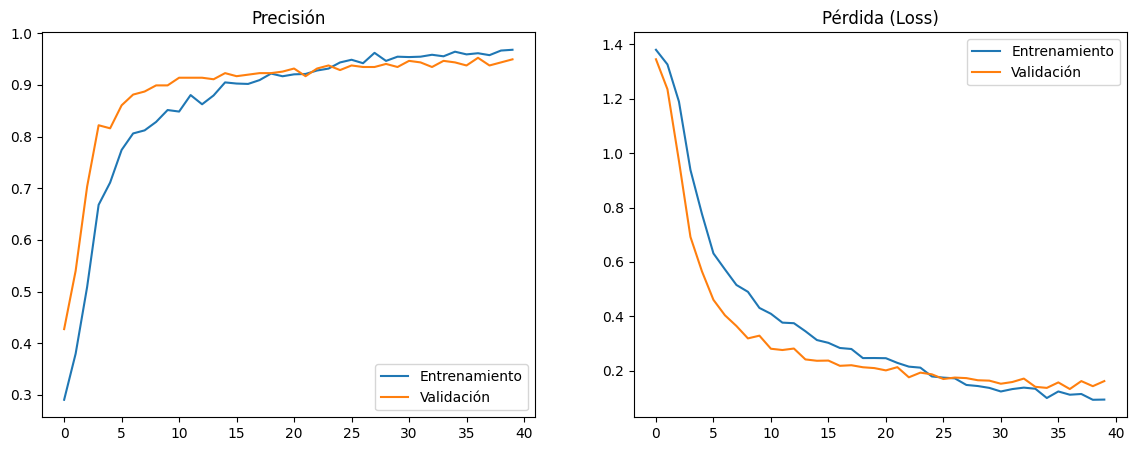

In [7]:
import matplotlib.pyplot as plt

def plot_historia_entrenamiento(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Entrenamiento')
    plt.plot(epochs_range, val_acc, label='Validación')
    plt.title('Precisión')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Entrenamiento')
    plt.plot(epochs_range, val_loss, label='Validación')
    plt.title('Pérdida (Loss)')
    plt.legend()

    plt.show()


plot_historia_entrenamiento(history)

In [8]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from io import BytesIO
from PIL import Image

def wav_a_tensor(wav_path, target_size=(128, 128)):
    # Cargar audio
    y, sr = librosa.load(wav_path, sr=None)

    # Crear espectrograma Mel
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)

    # Dibujar el espectrograma en memoria
    fig = plt.figure(figsize=(4, 4), dpi=100)  # esto genera 400x400 pero luego redimensionamos
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    librosa.display.specshow(S_dB, sr=sr, cmap='magma')

    # Guardar en buffer en memoria
    buf = BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
    plt.close(fig)
    buf.seek(0)

    # Convertir imagen desde el buffer
    image = Image.open(buf).convert('RGB')
    image = image.resize(target_size)
    image = np.array(image).astype(np.float32) / 255.0
    image_tensor = tf.expand_dims(image, axis=0)

    return image_tensor

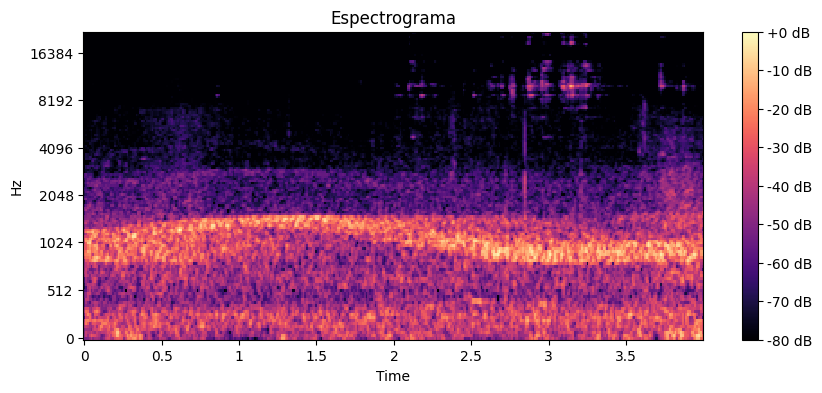

In [9]:
audio_predict_path = "datasets/UrbanSound8K/fold7/102853-8-0-4.wav"

y, sr = librosa.load(audio_predict_path, sr=44100)
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
S_db = librosa.amplitude_to_db(S, ref=np.max)

# Mostrar espectrograma
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title("Espectrograma")
plt.show()

In [10]:
image_tensor = wav_a_tensor(audio_predict_path)
print(image_tensor.shape)

(1, 128, 128, 3)


In [11]:
pred = model.predict(image_tensor)
pred_clase = np.argmax(pred, axis=1)[0]
etiqueta = label_encoder.inverse_transform([pred_clase])[0]

print(f"Predicción: {etiqueta}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Predicción: police


<Figure size 800x600 with 0 Axes>

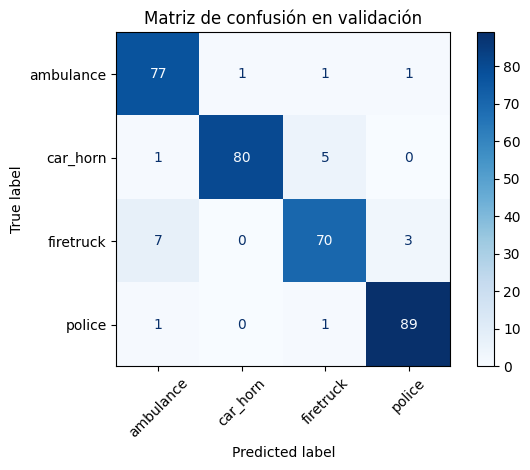

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Listas para etiquetas reales y predichas
y_true = []
y_pred = []

# Iterar sobre el conjunto de validación
for images, labels in val_ds.unbatch().take(1000):
    preds = model.predict(tf.expand_dims(images, axis=0), verbose=0)
    pred_label = np.argmax(preds)
    y_true.append(labels.numpy())
    y_pred.append(pred_label)

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Matriz de confusión en validación")
plt.tight_layout()
plt.show()

In [17]:
model.save("audio_model.h5")